# Bangla Sentiment Analysis - Complete Solution

This notebook implements a comprehensive sentiment analysis system for Bangla text, addressing underfitting issues with improved architecture and training strategies.

## 1. Setup and Imports

In [1]:
# Complete clean installation to avoid conflicts
!pip uninstall -y transformers tokenizers accelerate -q
!pip cache purge
!pip install --upgrade pip setuptools wheel -q

# Install specific compatible versions
!pip install torch==2.0.1 --index-url https://download.pytorch.org/whl/cu118 -q
!pip install transformers==4.30.2 -q
!pip install tokenizers==0.13.3 -q
!pip install accelerate==0.20.3 -q
!pip install datasets==2.13.1 -q
!pip install scikit-learn pandas numpy matplotlib seaborn tqdm -q

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 10.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━

In [2]:
import os
# Fix tokenizer warning
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

# Transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup
)

# System utilities
import gc
import json
import random
from datetime import datetime
import re
from collections import Counter, defaultdict
from difflib import SequenceMatcher

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create directories
for dir_name in ['plots', 'models', 'results', 'logs']:
    os.makedirs(dir_name, exist_ok=True)

print("Setup completed successfully!")

2025-07-21 05:33:20.024259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753076000.221597      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753076000.282311      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB
Setup completed successfully!


## 2. Load and Analyze Dataset

In [3]:
# Load dataset
df = pd.read_csv('/kaggle/input/final-dataset/final-dataset.csv')
#drop neutral columns
df = df[df['Polarity'] != 'neutral']
print(f"Original dataset shape: {df.shape}")

# Check unique polarities to determine number of classes
unique_polarities = df['Polarity'].unique()
print(f"\nUnique polarities found: {unique_polarities}")

# Map polarities based on what's in the dataset
if 'neutral' in unique_polarities:
    # 3-class case
    num_classes = 3
    df['Polarity'] = df['Polarity'].map({'positive': 1, 'negative': 0, 'neutral': 2})
    class_names = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
    print("\nDetected 3-class sentiment analysis")
else:
    # 2-class case
    num_classes = 2
    df['Polarity'] = df['Polarity'].map({'positive': 1, 'negative': 0})
    class_names = {0: 'Negative', 1: 'Positive'}
    print("\nDetected 2-class sentiment analysis")

print(f"Number of classes: {num_classes}")
print("\nClass distribution:")
print(df['Polarity'].value_counts().sort_index())

if num_classes == 2:
    print(f"\nClass balance ratio: {df['Polarity'].value_counts()[0] / df['Polarity'].value_counts()[1]:.2f}")

Original dataset shape: (4025, 2)

Unique polarities found: ['positive' 'negative']

Detected 2-class sentiment analysis
Number of classes: 2

Class distribution:
Polarity
0    1977
1    2048
Name: count, dtype: int64

Class balance ratio: 0.97


## 3. Comprehensive Data Quality Assessment

COMPREHENSIVE DATA QUALITY ASSESSMENT

1. BASIC STATISTICS:
Total samples: 4025
Number of classes: 2
Unique texts: 4020
Duplicate texts: 5
Duplicate ratio: 0.12%

2. TEXT LENGTH ANALYSIS:
Character length - Mean: 65.3, Std: 47.8
Word count - Mean: 11.0, Std: 8.2
Min/Max characters: 3/531
Min/Max words: 1/96

3. VOCABULARY ANALYSIS:
Total words: 44,161
Unique words: 11,857
Vocabulary richness: 0.2685
Words appearing only once: 7,869

4. CLASS-SPECIFIC PATTERNS:

Class 0 (Negative):
  Samples: 1977
  Avg length: 63.0 chars
  Avg words: 10.8
  Word diversity: 0.978

Class 1 (Positive):
  Samples: 2048
  Avg length: 67.5 chars
  Avg words: 11.1
  Word diversity: 0.976


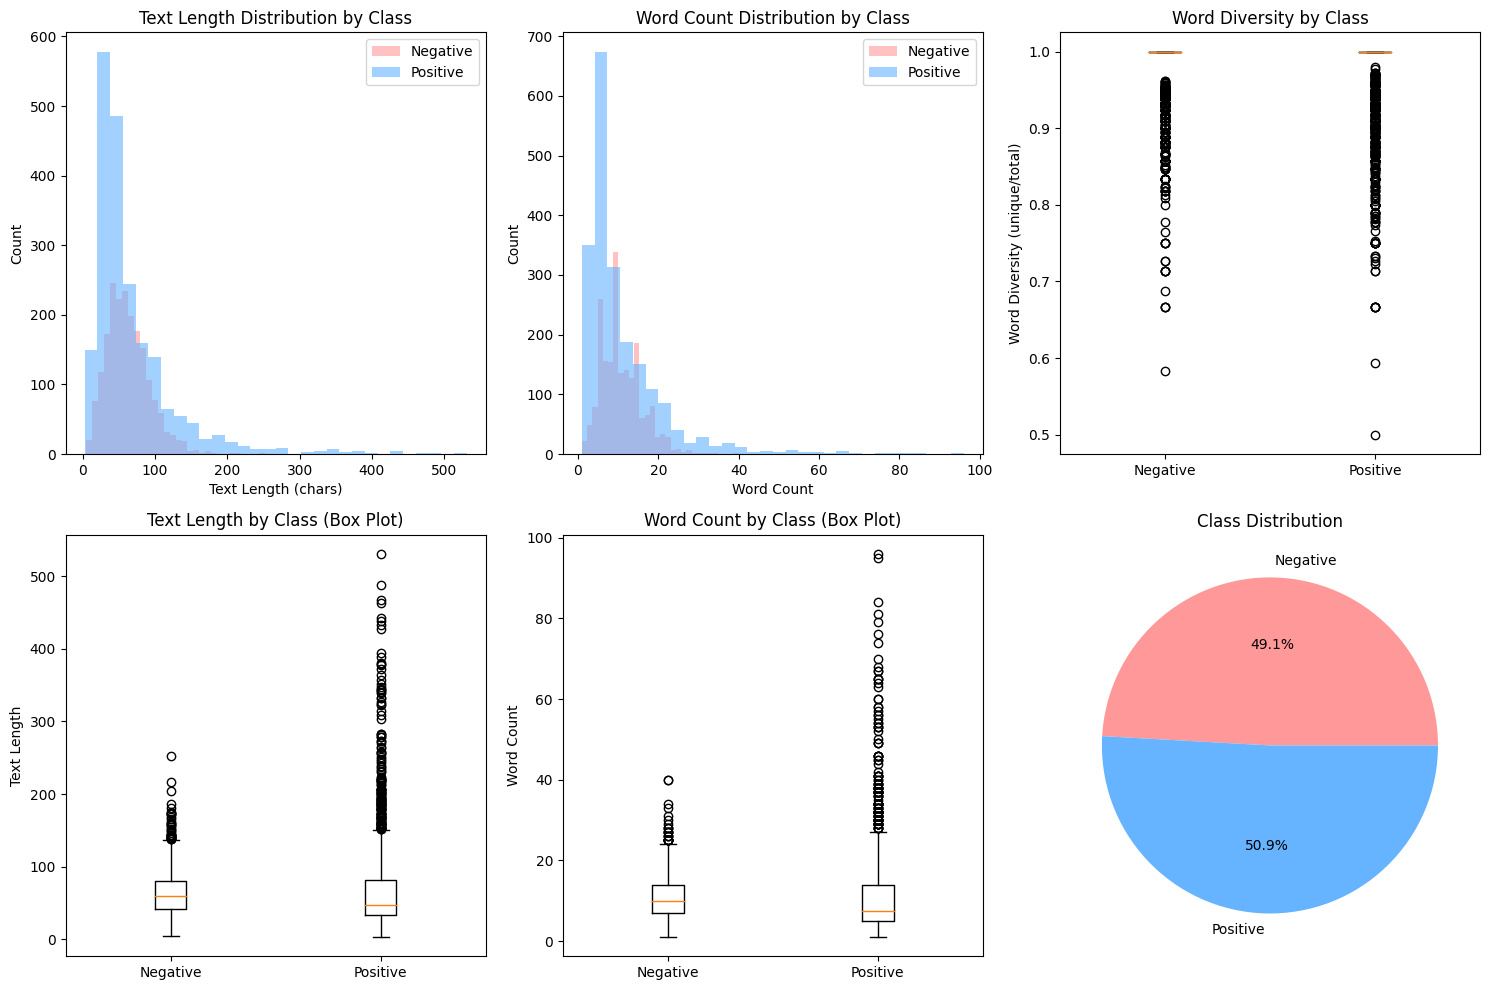


5. CLASS BALANCE ANALYSIS:
Negative: 49.1%
Positive: 50.9%

Imbalance ratio (max/min): 1.04


In [4]:
def comprehensive_data_assessment(df, num_classes=2, class_names=None):
    """Comprehensive data quality assessment with visualizations for 2 or 3-class sentiment"""
    print("="*70)
    print("COMPREHENSIVE DATA QUALITY ASSESSMENT")
    print("="*70)
    
    # Add text statistics
    df['text_length'] = df['Text'].str.len()
    df['word_count'] = df['Text'].str.split().str.len()
    df['unique_words'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['word_diversity'] = df['unique_words'] / df['word_count']
    
    # 1. Basic statistics
    print("\n1. BASIC STATISTICS:")
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {num_classes}")
    print(f"Unique texts: {df['Text'].nunique()}")
    print(f"Duplicate texts: {len(df) - df['Text'].nunique()}")
    print(f"Duplicate ratio: {(len(df) - df['Text'].nunique()) / len(df) * 100:.2f}%")
    
    # 2. Text length analysis
    print("\n2. TEXT LENGTH ANALYSIS:")
    print(f"Character length - Mean: {df['text_length'].mean():.1f}, Std: {df['text_length'].std():.1f}")
    print(f"Word count - Mean: {df['word_count'].mean():.1f}, Std: {df['word_count'].std():.1f}")
    print(f"Min/Max characters: {df['text_length'].min()}/{df['text_length'].max()}")
    print(f"Min/Max words: {df['word_count'].min()}/{df['word_count'].max()}")
    
    # 3. Vocabulary analysis
    all_words = ' '.join(df['Text']).split()
    word_freq = Counter(all_words)
    print(f"\n3. VOCABULARY ANALYSIS:")
    print(f"Total words: {len(all_words):,}")
    print(f"Unique words: {len(word_freq):,}")
    print(f"Vocabulary richness: {len(word_freq)/len(all_words):.4f}")
    print(f"Words appearing only once: {sum(1 for count in word_freq.values() if count == 1):,}")
    
    # 4. Class-specific analysis
    print("\n4. CLASS-SPECIFIC PATTERNS:")
    for polarity in range(num_classes):
        subset = df[df['Polarity'] == polarity]
        print(f"\nClass {polarity} ({class_names[polarity]}):")
        print(f"  Samples: {len(subset)}")
        print(f"  Avg length: {subset['text_length'].mean():.1f} chars")
        print(f"  Avg words: {subset['word_count'].mean():.1f}")
        print(f"  Word diversity: {subset['word_diversity'].mean():.3f}")
    
    # 5. Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Define colors for each class
    if num_classes == 2:
        colors = {0: '#ff9999', 1: '#66b3ff'}  # Red, Blue
        color_list = ['#ff9999', '#66b3ff']
    else:
        colors = {0: '#ff9999', 1: '#66b3ff', 2: '#99ff99'}  # Red, Blue, Green
        color_list = ['#ff9999', '#66b3ff', '#99ff99']
    
    # Text length distribution by class
    for polarity in range(num_classes):
        subset = df[df['Polarity'] == polarity]
        axes[0, 0].hist(subset['text_length'], bins=30, alpha=0.6, 
                       label=class_names[polarity], color=colors[polarity])
    axes[0, 0].set_xlabel('Text Length (chars)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].set_title('Text Length Distribution by Class')
    
    # Word count distribution
    for polarity in range(num_classes):
        subset = df[df['Polarity'] == polarity]
        axes[0, 1].hist(subset['word_count'], bins=30, alpha=0.6,
                       label=class_names[polarity], color=colors[polarity])
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
    axes[0, 1].set_title('Word Count Distribution by Class')
    
    # Word diversity
    word_diversity_data = [df[df['Polarity']==i]['word_diversity'] for i in range(num_classes)]
    axes[0, 2].boxplot(word_diversity_data, 
                      labels=[class_names[i] for i in range(num_classes)])
    axes[0, 2].set_ylabel('Word Diversity (unique/total)')
    axes[0, 2].set_title('Word Diversity by Class')
    
    # Length statistics boxplots
    text_length_data = [df[df['Polarity']==i]['text_length'] for i in range(num_classes)]
    axes[1, 0].boxplot(text_length_data, 
                      labels=[class_names[i] for i in range(num_classes)])
    axes[1, 0].set_ylabel('Text Length')
    axes[1, 0].set_title('Text Length by Class (Box Plot)')
    
    word_count_data = [df[df['Polarity']==i]['word_count'] for i in range(num_classes)]
    axes[1, 1].boxplot(word_count_data, 
                      labels=[class_names[i] for i in range(num_classes)])
    axes[1, 1].set_ylabel('Word Count')
    axes[1, 1].set_title('Word Count by Class (Box Plot)')
    
    # Class distribution
    class_counts = df['Polarity'].value_counts().sort_index()
    axes[1, 2].pie(class_counts.values, 
                   labels=[class_names[i] for i in range(num_classes)], 
                   autopct='%1.1f%%', 
                   colors=color_list[:num_classes])
    axes[1, 2].set_title('Class Distribution')
    
    plt.tight_layout()
    plt.savefig(f'plots/data_quality_assessment_{num_classes}class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional statistics
    print("\n5. CLASS BALANCE ANALYSIS:")
    class_percentages = df['Polarity'].value_counts(normalize=True).sort_index() * 100
    for polarity in range(num_classes):
        print(f"{class_names[polarity]}: {class_percentages.get(polarity, 0):.1f}%")
    
    # Check for class imbalance
    min_class_pct = class_percentages.min()
    max_class_pct = class_percentages.max()
    imbalance_ratio = max_class_pct / min_class_pct
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")
    if imbalance_ratio > 3:
        print("⚠️  WARNING: Significant class imbalance detected!")
    
    return df

# Run assessment with dynamic class detection
df = comprehensive_data_assessment(df, num_classes=num_classes, class_names=class_names)

## 4. Advanced Data Cleaning and Preprocessing

In [5]:
def advanced_data_cleaning(df):
    """Advanced data cleaning with similarity detection"""
    print("\n" + "="*70)
    print("ADVANCED DATA CLEANING")
    print("="*70)
    
    original_size = len(df)
    
    # 1. Remove exact duplicates
    df = df.drop_duplicates(subset=['Text'], keep='first')
    print(f"\n1. Removed {original_size - len(df)} exact duplicates")
    
    # 2. Remove very short texts
    min_words = 3
    df = df[df['word_count'] >= min_words]
    print(f"2. Removed texts with less than {min_words} words. Size: {len(df)}")
    
    # 3. Remove punctuation-only variations
    df['text_normalized'] = df['Text'].str.replace(r'[।!|.?]+', ' ', regex=True).str.strip()
    df['text_normalized'] = df['text_normalized'].str.replace(r'\s+', ' ', regex=True)
    before_punct = len(df)
    df = df.drop_duplicates(subset=['text_normalized'], keep='first')
    print(f"3. Removed {before_punct - len(df)} punctuation variations")
    
    # 4. Remove outliers by length
    q1 = df['text_length'].quantile(0.01)
    q99 = df['text_length'].quantile(0.99)
    before_outliers = len(df)
    df = df[(df['text_length'] >= q1) & (df['text_length'] <= q99)]
    print(f"4. Removed {before_outliers - len(df)} length outliers")
    
    # 5. Check for high similarity texts (on sample for efficiency)
    print("\n5. Checking for highly similar texts...")
    if len(df) > 1000:
        sample_size = min(1000, len(df))
        sample_df = df.sample(sample_size, random_state=42)
        
        vectorizer = TfidfVectorizer(max_features=500)
        tfidf_matrix = vectorizer.fit_transform(sample_df['Text'])
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        high_similarity_count = 0
        for i in range(len(similarity_matrix)):
            for j in range(i+1, len(similarity_matrix)):
                if similarity_matrix[i][j] > 0.90:
                    high_similarity_count += 1
        
        print(f"   Found {high_similarity_count} highly similar pairs (>90%) in sample of {sample_size}")
    
    # Clean up temporary columns
    df = df.drop(['text_normalized'], axis=1)
    
    # Reset index
    df = df.reset_index(drop=True)
    
    print(f"\nFinal dataset size: {len(df)} (removed {original_size - len(df)} total)")
    print(f"Reduction: {(original_size - len(df)) / original_size * 100:.1f}%")
    
    # Final class distribution
    print("\nFinal class distribution:")
    print(df['Polarity'].value_counts())
    
    return df

# Clean the data
df_clean = advanced_data_cleaning(df)


ADVANCED DATA CLEANING

1. Removed 5 exact duplicates
2. Removed texts with less than 3 words. Size: 3931
3. Removed 47 punctuation variations
4. Removed 72 length outliers

5. Checking for highly similar texts...
   Found 21 highly similar pairs (>90%) in sample of 1000

Final dataset size: 3812 (removed 213 total)
Reduction: 5.3%

Final class distribution:
Polarity
1    1910
0    1902
Name: count, dtype: int64


## 5. Model Configuration

In [6]:
# Model configurations optimized for Bengali/Bangla sentiment analysis
MODEL_CONFIGS = {
    'banglabert': {
        'name': 'csebuetnlp/banglabert',
        'max_length': 128,
        'model_type': 'banglabert'
    },
    'indic-bert': {
        'name': 'ai4bharat/indic-bert',
        'max_length': 128,
        'model_type': 'indic-bert'
    },
    'xlm-roberta': {
        'name': 'xlm-roberta-base',
        'max_length': 128,
        'model_type': 'xlm-roberta'
    },
    'muril': {
        'name': 'google/muril-base-cased',
        'max_length': 128,
        'model_type': 'muril'
    }
}

# ====================================================================
# CHANGE THIS VARIABLE TO SELECT DIFFERENT MODEL
# Options: 'banglabert', 'indic-bert', 'xlm-roberta', 'muril'
# ====================================================================
SELECTED_MODEL = 'banglabert'  # <-- Change this to switch models
# ====================================================================

# Training configuration optimized for small dataset with underfitting issues
TRAINING_CONFIG = {
    'num_epochs': 15,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'gradient_accumulation_steps': 1,
    'fp16': True,
    'seed': 42,
    'label_smoothing_factor': 0.1,
    'lr_scheduler_type': 'cosine',
    'adam_epsilon': 1e-8,
    'max_grad_norm': 1.0,
    'eval_steps': 50,
    'save_steps': 100,
    'logging_steps': 25,
    'early_stopping_patience': 7,
    'early_stopping_threshold': 0.0001,
    'dropout_rate': 0.3,
    'hidden_dropout_prob': 0.3,
    'attention_dropout_prob': 0.3
}

# Display selected configuration
print("="*70)
print("MODEL SELECTION")
print("="*70)
print("\nAvailable models:")
for model_key in MODEL_CONFIGS:
    status = "✓ SELECTED" if model_key == SELECTED_MODEL else "  "
    print(f"{status} {model_key}: {MODEL_CONFIGS[model_key]['name']}")

print(f"\nActive Configuration:")
print(f"Selected model: {SELECTED_MODEL}")
print(f"Model name: {MODEL_CONFIGS[SELECTED_MODEL]['name']}")
print(f"Model type: {MODEL_CONFIGS[SELECTED_MODEL]['model_type']}")
print(f"Max length: {MODEL_CONFIGS[SELECTED_MODEL]['max_length']}")
print(f"\nTraining Configuration:")
print(f"Epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"Learning rate: {TRAINING_CONFIG['learning_rate']}")
print("="*70)

MODEL SELECTION

Available models:
✓ SELECTED banglabert: csebuetnlp/banglabert
   indic-bert: ai4bharat/indic-bert
   xlm-roberta: xlm-roberta-base
   muril: google/muril-base-cased

Active Configuration:
Selected model: banglabert
Model name: csebuetnlp/banglabert
Model type: banglabert
Max length: 128

Training Configuration:
Epochs: 15
Batch size: 32
Learning rate: 2e-05


## 6. Dataset Class with Augmentation

In [7]:
class BanglaDataset(Dataset):
    """Dataset class with optional augmentation"""
    def __init__(self, texts, labels, tokenizer, max_length=128, 
                 is_training=True, augment=False, aug_prob=0.3):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_training = is_training
        self.augment = augment and is_training
        self.aug_prob = aug_prob
    
    def __len__(self):
        return len(self.texts)
    
    def augment_text(self, text):
        """Simple augmentation techniques for Bangla text"""
        if random.random() > self.aug_prob:
            return text
        
        aug_type = random.choice(['punct', 'repeat', 'shuffle'])
        
        if aug_type == 'punct':
            # Add or change punctuation
            punctuations = ['।', '!', '?', '...']
            text = text.rstrip('।!?. ') + ' ' + random.choice(punctuations)
        
        elif aug_type == 'repeat':
            # Repeat a random word for emphasis
            words = text.split()
            if len(words) > 5:
                idx = random.randint(1, len(words)-2)
                words.insert(idx+1, words[idx])
                text = ' '.join(words)
        
        elif aug_type == 'shuffle':
            # Shuffle middle words (keep first and last)
            words = text.split()
            if len(words) > 4:
                middle = words[1:-1]
                random.shuffle(middle)
                text = ' '.join([words[0]] + middle + [words[-1]])
        
        return text
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Apply augmentation if enabled
        if self.augment:
            text = self.augment_text(text)
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            add_special_tokens=True
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## 7. Improved Model Architecture

In [8]:
class ImprovedBanglaClassifier(nn.Module):
    """Enhanced classifier with proper dimension handling"""
    def __init__(self, model_name, num_labels=2, config=None):
        super().__init__()
        
        # Store num_labels
        self.num_labels = num_labels
        
        # Load pre-trained model and get configuration
        self.bert = AutoModel.from_pretrained(model_name)
        self.config = self.bert.config
        
        # Get the actual hidden size from the model
        if hasattr(self.config, 'hidden_size'):
            hidden_size = self.config.hidden_size
        else:
            # Try to infer from the model
            hidden_size = 768  # Default BERT size
            
        print(f"Model hidden size: {hidden_size}")
        print(f"Number of labels: {num_labels}")
        
        # Build classifier with correct dimensions
        self.pre_classifier = nn.Linear(hidden_size, hidden_size)
        self.dropout1 = nn.Dropout(config.get('dropout_rate', 0.3) if config else 0.3)
        
        # Use consistent dimensions
        self.classifier = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout((config.get('dropout_rate', 0.3) if config else 0.3) / 2)
        
        self.output = nn.Linear(hidden_size // 2, num_labels)
        
        # Activation and normalization with correct dimensions
        self.activation = nn.GELU()
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size // 2)  # This should match classifier output
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize classifier weights"""
        for module in [self.pre_classifier, self.classifier, self.output]:
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def forward(self, input_ids, attention_mask, labels=None):
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Extract the appropriate hidden state
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            hidden_state = outputs.pooler_output
        else:
            # Use CLS token from last hidden state
            hidden_state = outputs.last_hidden_state[:, 0, :]
        
        # Apply layer norm to the correct dimension
        x = self.layer_norm1(hidden_state)
        x = self.dropout1(x)
        x = self.pre_classifier(x)
        x = self.activation(x)
        
        # Now x has hidden_size dimensions, classifier reduces to hidden_size // 2
        x = self.classifier(x)
        x = self.activation(x)
        x = self.layer_norm2(x)  # Now this expects hidden_size // 2
        x = self.dropout2(x)
        
        logits = self.output(x)
        
        # Calculate loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {
            'loss': loss,
            'logits': logits,
            'hidden_states': outputs.hidden_states if hasattr(outputs, 'hidden_states') else None
        }

## 8. Custom Training Implementation

In [9]:
class CustomTrainer:
    """Custom trainer with advanced features"""
    def __init__(self, model, tokenizer, train_dataset, val_dataset, config, device):
        self.model = model
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.config = config
        self.device = device
        
        # Create dataloaders
        self.train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'],
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'] * 2,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Setup optimizer with layer-wise learning rates
        self.optimizer = self._create_optimizer()
        
        # Setup scheduler
        num_training_steps = len(self.train_loader) * config['num_epochs']
        num_warmup_steps = int(num_training_steps * config['warmup_ratio'])
        
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )
        
        # Initialize tracking
        self.train_losses = []
        self.val_losses = []
        self.val_metrics = []
        self.best_val_f1 = 0
        self.best_model_state = None
        self.patience_counter = 0
        
    def _create_optimizer(self):
        """Create optimizer with different learning rates for different layers"""
        # Separate parameters
        bert_params = []
        classifier_params = []
        
        for name, param in self.model.named_parameters():
            if 'bert' in name.lower() or 'electra' in name.lower() or 'model' in name.lower():
                bert_params.append(param)
            else:
                classifier_params.append(param)
        
        optimizer = AdamW([
            {'params': bert_params, 'lr': self.config['learning_rate'] * 0.5},
            {'params': classifier_params, 'lr': self.config['learning_rate']}
        ], 
        eps=self.config['adam_epsilon'],
        weight_decay=self.config['weight_decay']
        )
        
        return optimizer
    
    def train_epoch(self, epoch):
        """Train for one epoch with correct loss tracking"""
        self.model.train()
        total_loss = 0
        total_samples = 0  # Track number of samples
        predictions = []
        true_labels = []
    
        progress_bar = tqdm(self.train_loader, desc=f'Training Epoch {epoch}')
    
        for batch_idx, batch in enumerate(progress_bar):
            # Move to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
        
            # Forward pass
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
        
            # Get the loss
            loss = outputs['loss']
        
            # Backward pass
            loss.backward()
        
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(), 
                self.config['max_grad_norm']
            )
        
            # Optimizer step
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()
        
            # Track metrics correctly
            batch_size = input_ids.size(0)
            total_loss += loss.item() * batch_size  # Weight by batch size
            total_samples += batch_size
        
            # Predictions
            preds = torch.argmax(outputs['logits'], dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
            # Update progress bar with running average
            current_loss = total_loss / total_samples
            current_acc = accuracy_score(true_labels, predictions)
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.4f}'
            })
    
        # Calculate correct averages
        avg_loss = total_loss / total_samples
        train_acc = accuracy_score(true_labels, predictions)
    
        return avg_loss, train_acc
    
    def evaluate(self, dataloader=None):
        """Evaluate the model with correct loss tracking"""
        if dataloader is None:
            dataloader = self.val_loader
        
        self.model.eval()
        total_loss = 0
        total_samples = 0
        all_predictions = []
        all_labels = []
        all_probs = []
    
        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Evaluating'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
            
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
            
                # Track loss correctly
                batch_size = input_ids.size(0)
                loss = outputs['loss']
                total_loss += loss.item() * batch_size
                total_samples += batch_size
            
                # Get predictions and probabilities
                logits = outputs['logits']
                probs = F.softmax(logits, dim=-1)
                preds = torch.argmax(logits, dim=-1)
            
                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
    
        # Calculate correct average loss
        avg_loss = total_loss / total_samples
        accuracy = accuracy_score(all_labels, all_predictions)
        
        # Determine number of classes from the labels
        num_classes = len(np.unique(all_labels))
        
        if num_classes == 2:
            # Binary classification metrics
            f1 = f1_score(all_labels, all_predictions, average='weighted')
            f1_neg = f1_score(all_labels, all_predictions, pos_label=0, average='binary')
            f1_pos = f1_score(all_labels, all_predictions, pos_label=1, average='binary')
            
            metrics = {
                'loss': avg_loss,
                'accuracy': accuracy,
                'f1': f1,
                'f1_negative': f1_neg,
                'f1_positive': f1_pos
            }
        else:
            # Multi-class metrics
            f1 = f1_score(all_labels, all_predictions, average='weighted')
            f1_macro = f1_score(all_labels, all_predictions, average='macro')
            
            # Per-class F1 scores
            f1_per_class = f1_score(all_labels, all_predictions, average=None)
            
            metrics = {
                'loss': avg_loss,
                'accuracy': accuracy,
                'f1': f1,
                'f1_macro': f1_macro,
                'f1_per_class': f1_per_class
            }
            
            # Add per-class metrics
            for i in range(num_classes):
                if i < len(f1_per_class):
                    metrics[f'f1_class_{i}'] = f1_per_class[i]
    
        return metrics, np.array(all_predictions), np.array(all_labels), np.array(all_probs)
    
    def train(self):
        """Full training loop"""
        print("\nStarting training...")
        print("="*70)
        
        for epoch in range(1, self.config['num_epochs'] + 1):
            # Training
            train_loss, train_acc = self.train_epoch(epoch)
            self.train_losses.append(train_loss)
            
            # Validation
            val_metrics, _, _, _ = self.evaluate()
            self.val_losses.append(val_metrics['loss'])
            self.val_metrics.append(val_metrics)
            
            # Print epoch summary
            print(f"\nEpoch {epoch}/{self.config['num_epochs']}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")
            print(f"Val F1: {val_metrics['f1']:.4f}", end='')
            
            # Print appropriate metrics based on number of classes
            if 'f1_negative' in val_metrics:
                # Binary classification
                print(f" (Neg: {val_metrics['f1_negative']:.4f}, Pos: {val_metrics['f1_positive']:.4f})")
            else:
                # Multi-class
                print(f" (Macro: {val_metrics.get('f1_macro', 0):.4f})")
                # Print per-class F1
                for i in range(10):  # Check up to 10 classes
                    if f'f1_class_{i}' in val_metrics:
                        print(f"  Class {i} F1: {val_metrics[f'f1_class_{i}']:.4f}", end='')
                print()  # New line
            
            # Early stopping based on F1 score
            if val_metrics['f1'] > self.best_val_f1 + self.config['early_stopping_threshold']:
                self.best_val_f1 = val_metrics['f1']
                self.best_model_state = self.model.state_dict()
                self.patience_counter = 0
                print(f"✓ New best model! F1: {self.best_val_f1:.4f}")
            else:
                self.patience_counter += 1
                print(f"✗ No improvement. Patience: {self.patience_counter}/{self.config['early_stopping_patience']}")
            
            if self.patience_counter >= self.config['early_stopping_patience']:
                print(f"\nEarly stopping triggered after {epoch} epochs")
                break
            
            print("-"*70)
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f"\nLoaded best model with F1: {self.best_val_f1:.4f}")
        
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_metrics': self.val_metrics,
            'best_f1': self.best_val_f1
        }

## 9. K-Fold Cross Validation

In [10]:
class SimpleBanglaClassifier(nn.Module):
    """Simplified classifier that adapts to any model"""
    def __init__(self, model_name, num_labels=2, config=None):
        super().__init__()
        
        # Store num_labels
        self.num_labels = num_labels
        
        # Try loading as sequence classification model first
        try:
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name,
                num_labels=num_labels,
                ignore_mismatched_sizes=True
            )
            self.is_seq_model = True
            print(f"Loaded {model_name} as sequence classification model with {num_labels} labels")
        except:
            # Load as base model
            self.model = AutoModel.from_pretrained(model_name)
            self.is_seq_model = False
            
            # Get hidden size
            if hasattr(self.model.config, 'hidden_size'):
                hidden_size = self.model.config.hidden_size
            else:
                # Try to get it from the model output
                dummy_input = torch.zeros(1, 10, dtype=torch.long)
                with torch.no_grad():
                    dummy_output = self.model(dummy_input)
                    if hasattr(dummy_output, 'last_hidden_state'):
                        hidden_size = dummy_output.last_hidden_state.shape[-1]
                    else:
                        hidden_size = 768  # Default
            
            print(f"Loaded {model_name} as base model with hidden size {hidden_size} and {num_labels} labels")
            
            # Simple classifier head
            dropout_rate = config.get('dropout_rate', 0.3) if config else 0.3
            self.dropout = nn.Dropout(dropout_rate)
            self.classifier = nn.Linear(hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        if self.is_seq_model:
            # Use the model's built-in classification
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            return {
                'loss': outputs.loss if hasattr(outputs, 'loss') else None,
                'logits': outputs.logits,
                'hidden_states': outputs.hidden_states if hasattr(outputs, 'hidden_states') else None
            }
        else:
            # Custom classification
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get pooled output
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                pooled_output = outputs.pooler_output
            else:
                # Mean pooling
                hidden_states = outputs.last_hidden_state
                pooled_output = hidden_states.mean(dim=1)
            
            # Apply dropout and classifier
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)
            
            # Calculate loss
            loss = None
            if labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits, labels)
            
            return {
                'loss': loss,
                'logits': logits,
                'hidden_states': None
            }

print("SimpleBanglaClassifier defined successfully")

SimpleBanglaClassifier defined successfully


In [11]:
# Use the simplified model for stability
print(f"Using simplified model architecture for better compatibility")
print(f"Running K-Fold CV with: {SELECTED_MODEL}")

# Replace ImprovedBanglaClassifier with SimpleBanglaClassifier in the k-fold function
def kfold_cross_validation(df, model_config, training_config, n_splits=5, use_augmentation=True, num_classes=2, class_names=None):
    """K-fold cross validation with proper implementation for 2 or 3 classes"""
    
    texts = df['Text'].values
    labels = df['Polarity'].values
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_config['name'])
    
    # K-fold setup
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=training_config['seed'])
    
    # Results storage
    cv_results = {
        'fold_metrics': [],
        'all_predictions': [],
        'all_labels': [],
        'all_probs': []
    }
    
    print(f"\nStarting {n_splits}-Fold Cross Validation for {num_classes}-class classification")
    print(f"Model: {model_config['name']}")
    print("="*70)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), 1):
        print(f"\nFOLD {fold}/{n_splits}")
        print("-"*50)
        
        # Split data
        X_train, X_val = texts[train_idx], texts[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        print(f"Train: {len(X_train)} samples")
        print(f"Val: {len(X_val)} samples")
        print(f"Class distribution - Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}")
        
        # Create datasets
        train_dataset = BanglaDataset(
            X_train, y_train, tokenizer, 
            max_length=model_config['max_length'],
            is_training=True,
            augment=use_augmentation
        )
        
        val_dataset = BanglaDataset(
            X_val, y_val, tokenizer,
            max_length=model_config['max_length'],
            is_training=False,
            augment=False
        )
        
        # Initialize model - Use SimpleBanglaClassifier
        model = SimpleBanglaClassifier(
            model_config['name'],
            num_labels=num_classes,
            config=training_config
        ).to(device)
        
        # Train
        trainer = CustomTrainer(
            model=model,
            tokenizer=tokenizer,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            config=training_config,
            device=device
        )
        
        # Train the model
        train_history = trainer.train()
        
        # Final evaluation
        metrics, predictions, true_labels, probs = trainer.evaluate()
        
        # Store results
        cv_results['fold_metrics'].append(metrics)
        cv_results['all_predictions'].extend(predictions)
        cv_results['all_labels'].extend(true_labels)
        cv_results['all_probs'].extend(probs)
        
        print(f"\nFold {fold} Final Results:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"F1 Score: {metrics['f1']:.4f}")
        
        if num_classes == 2:
            print(f"F1 Negative: {metrics['f1_negative']:.4f}")
            print(f"F1 Positive: {metrics['f1_positive']:.4f}")
        else:
            print(f"F1 Macro: {metrics.get('f1_macro', 'N/A'):.4f}")
            for i in range(num_classes):
                print(f"F1 {class_names[i]}: {metrics.get(f'f1_class_{i}', 'N/A'):.4f}")
        
        # Clean up
        del model, trainer
        torch.cuda.empty_cache()
        gc.collect()
    
    # Calculate average metrics
    print("\n" + "="*70)
    print("CROSS-VALIDATION SUMMARY")
    print(f"Model: {model_config['name']}")
    print("="*70)
    
    avg_metrics = {}
    
    # Common metrics
    for metric in ['accuracy', 'f1', 'loss']:
        if metric in cv_results['fold_metrics'][0]:
            values = [fold[metric] for fold in cv_results['fold_metrics']]
            avg_metrics[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'values': values
            }
            print(f"{metric}: {avg_metrics[metric]['mean']:.4f} (+/- {avg_metrics[metric]['std']:.4f})")
    
    # Class-specific metrics
    if num_classes == 2:
        for metric in ['f1_negative', 'f1_positive']:
            values = [fold[metric] for fold in cv_results['fold_metrics']]
            avg_metrics[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'values': values
            }
            print(f"{metric}: {avg_metrics[metric]['mean']:.4f} (+/- {avg_metrics[metric]['std']:.4f})")
    else:
        # Multi-class metrics
        if 'f1_macro' in cv_results['fold_metrics'][0]:
            values = [fold['f1_macro'] for fold in cv_results['fold_metrics']]
            avg_metrics['f1_macro'] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'values': values
            }
            print(f"f1_macro: {avg_metrics['f1_macro']['mean']:.4f} (+/- {avg_metrics['f1_macro']['std']:.4f})")
        
        # Per-class F1
        for i in range(num_classes):
            metric_name = f'f1_class_{i}'
            if metric_name in cv_results['fold_metrics'][0]:
                values = [fold[metric_name] for fold in cv_results['fold_metrics']]
                avg_metrics[metric_name] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'values': values
                }
                print(f"F1 {class_names[i]}: {avg_metrics[metric_name]['mean']:.4f} (+/- {avg_metrics[metric_name]['std']:.4f})")
    
    return cv_results, avg_metrics

# Run cross-validation with the SELECTED MODEL
cv_results, avg_metrics = kfold_cross_validation(
    df_clean,
    MODEL_CONFIGS[SELECTED_MODEL],  # Uses the selected model
    TRAINING_CONFIG,
    n_splits=5,
    use_augmentation=True,
    num_classes=num_classes,
    class_names=class_names
)

Using simplified model architecture for better compatibility
Running K-Fold CV with: banglabert


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Starting 5-Fold Cross Validation for 2-class classification
Model: csebuetnlp/banglabert

FOLD 1/5
--------------------------------------------------
Train: 3049 samples
Val: 763 samples
Class distribution - Train: [1521 1528], Val: [381 382]


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Loaded csebuetnlp/banglabert as sequence classification model with 2 labels

Starting training...


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6809, Train Acc: 0.5881
Val Loss: 0.6408, Val Acc: 0.6841
Val F1: 0.6734 (Neg: 0.7325, Pos: 0.6144)
✓ New best model! F1: 0.6734
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.4703, Train Acc: 0.8216
Val Loss: 0.3603, Val Acc: 0.8624
Val F1: 0.8623 (Neg: 0.8659, Pos: 0.8587)
✓ New best model! F1: 0.8623
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.2905, Train Acc: 0.9065
Val Loss: 0.3820, Val Acc: 0.8637
Val F1: 0.8634 (Neg: 0.8567, Pos: 0.8700)
✓ New best model! F1: 0.8634
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.2159, Train Acc: 0.9337
Val Loss: 0.3622, Val Acc: 0.8768
Val F1: 0.8767 (Neg: 0.8737, Pos: 0.8798)
✓ New best model! F1: 0.8767
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 0.1814, Train Acc: 0.9462
Val Loss: 0.3942, Val Acc: 0.8689
Val F1: 0.8688 (Neg: 0.8649, Pos: 0.8728)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.1535, Train Acc: 0.9570
Val Loss: 0.4381, Val Acc: 0.8689
Val F1: 0.8689 (Neg: 0.8721, Pos: 0.8656)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.1305, Train Acc: 0.9646
Val Loss: 0.4087, Val Acc: 0.8755
Val F1: 0.8754 (Neg: 0.8711, Pos: 0.8796)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.1104, Train Acc: 0.9715
Val Loss: 0.4351, Val Acc: 0.8820
Val F1: 0.8820 (Neg: 0.8819, Pos: 0.8822)
✓ New best model! F1: 0.8820
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.0891, Train Acc: 0.9784
Val Loss: 0.4875, Val Acc: 0.8676
Val F1: 0.8675 (Neg: 0.8626, Pos: 0.8723)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.0904, Train Acc: 0.9780
Val Loss: 0.4804, Val Acc: 0.8755
Val F1: 0.8755 (Neg: 0.8738, Pos: 0.8771)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.0747, Train Acc: 0.9820
Val Loss: 0.4952, Val Acc: 0.8768
Val F1: 0.8768 (Neg: 0.8782, Pos: 0.8753)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 12:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/15
Train Loss: 0.0674, Train Acc: 0.9826
Val Loss: 0.5060, Val Acc: 0.8781
Val F1: 0.8781 (Neg: 0.8755, Pos: 0.8806)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 13:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/15
Train Loss: 0.0657, Train Acc: 0.9839
Val Loss: 0.4965, Val Acc: 0.8847
Val F1: 0.8847 (Neg: 0.8842, Pos: 0.8851)
✓ New best model! F1: 0.8847
----------------------------------------------------------------------


Training Epoch 14:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/15
Train Loss: 0.0571, Train Acc: 0.9866
Val Loss: 0.5049, Val Acc: 0.8807
Val F1: 0.8807 (Neg: 0.8807, Pos: 0.8807)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 15:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/15
Train Loss: 0.0495, Train Acc: 0.9879
Val Loss: 0.5080, Val Acc: 0.8807
Val F1: 0.8807 (Neg: 0.8807, Pos: 0.8807)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------

Loaded best model with F1: 0.8847


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Fold 1 Final Results:
Accuracy: 0.8807
F1 Score: 0.8807
F1 Negative: 0.8807
F1 Positive: 0.8807

FOLD 2/5
--------------------------------------------------
Train: 3049 samples
Val: 763 samples
Class distribution - Train: [1521 1528], Val: [381 382]


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Loaded csebuetnlp/banglabert as sequence classification model with 2 labels

Starting training...


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6803, Train Acc: 0.5769
Val Loss: 0.6356, Val Acc: 0.7012
Val F1: 0.7005 (Neg: 0.7143, Pos: 0.6868)
✓ New best model! F1: 0.7005
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.4598, Train Acc: 0.8308
Val Loss: 0.3475, Val Acc: 0.8663
Val F1: 0.8663 (Neg: 0.8636, Pos: 0.8689)
✓ New best model! F1: 0.8663
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.2781, Train Acc: 0.9055
Val Loss: 0.3434, Val Acc: 0.8663
Val F1: 0.8658 (Neg: 0.8575, Pos: 0.8741)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.2186, Train Acc: 0.9334
Val Loss: 0.3343, Val Acc: 0.8899
Val F1: 0.8899 (Neg: 0.8903, Pos: 0.8895)
✓ New best model! F1: 0.8899
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 0.1757, Train Acc: 0.9488
Val Loss: 0.3763, Val Acc: 0.8729
Val F1: 0.8725 (Neg: 0.8658, Pos: 0.8792)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.1518, Train Acc: 0.9564
Val Loss: 0.3832, Val Acc: 0.8847
Val F1: 0.8845 (Neg: 0.8808, Pos: 0.8883)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.1218, Train Acc: 0.9685
Val Loss: 0.4096, Val Acc: 0.8886
Val F1: 0.8886 (Neg: 0.8871, Pos: 0.8900)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.1153, Train Acc: 0.9685
Val Loss: 0.4261, Val Acc: 0.8860
Val F1: 0.8860 (Neg: 0.8842, Pos: 0.8877)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.0985, Train Acc: 0.9757
Val Loss: 0.4444, Val Acc: 0.8847
Val F1: 0.8847 (Neg: 0.8839, Pos: 0.8854)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.0723, Train Acc: 0.9829
Val Loss: 0.4694, Val Acc: 0.8899
Val F1: 0.8899 (Neg: 0.8892, Pos: 0.8906)
✗ No improvement. Patience: 6/7
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.0733, Train Acc: 0.9826
Val Loss: 0.4779, Val Acc: 0.8820
Val F1: 0.8820 (Neg: 0.8834, Pos: 0.8806)
✗ No improvement. Patience: 7/7

Early stopping triggered after 11 epochs

Loaded best model with F1: 0.8899


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Fold 2 Final Results:
Accuracy: 0.8820
F1 Score: 0.8820
F1 Negative: 0.8834
F1 Positive: 0.8806

FOLD 3/5
--------------------------------------------------
Train: 3050 samples
Val: 762 samples
Class distribution - Train: [1522 1528], Val: [380 382]


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Loaded csebuetnlp/banglabert as sequence classification model with 2 labels

Starting training...


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6772, Train Acc: 0.5810
Val Loss: 0.6228, Val Acc: 0.6929
Val F1: 0.6923 (Neg: 0.6786, Pos: 0.7060)
✓ New best model! F1: 0.6923
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 14

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.4691, Train Acc: 0.8157
Val Loss: 0.3349, Val Acc: 0.8793
Val F1: 0.8793 (Neg: 0.8786, Pos: 0.8799)
✓ New best model! F1: 0.8793
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.2858, Train Acc: 0.8997
Val Loss: 0.3030, Val Acc: 0.8885
Val F1: 0.8884 (Neg: 0.8900, Pos: 0.8868)
✓ New best model! F1: 0.8884
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.2290, Train Acc: 0.9233
Val Loss: 0.3141, Val Acc: 0.8937
Val F1: 0.8935 (Neg: 0.8892, Pos: 0.8979)
✓ New best model! F1: 0.8935
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 0.1656, Train Acc: 0.9515
Val Loss: 0.3287, Val Acc: 0.8911
Val F1: 0.8911 (Neg: 0.8906, Pos: 0.8915)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.1301, Train Acc: 0.9639
Val Loss: 0.3750, Val Acc: 0.8858
Val F1: 0.8858 (Neg: 0.8848, Pos: 0.8869)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.1034, Train Acc: 0.9734
Val Loss: 0.4235, Val Acc: 0.8858
Val F1: 0.8857 (Neg: 0.8813, Pos: 0.8900)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.0934, Train Acc: 0.9754
Val Loss: 0.4347, Val Acc: 0.8845
Val F1: 0.8845 (Neg: 0.8824, Pos: 0.8866)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.0819, Train Acc: 0.9774
Val Loss: 0.4356, Val Acc: 0.8832
Val F1: 0.8832 (Neg: 0.8815, Pos: 0.8849)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.0657, Train Acc: 0.9856
Val Loss: 0.4766, Val Acc: 0.8806
Val F1: 0.8806 (Neg: 0.8788, Pos: 0.8823)
✗ No improvement. Patience: 6/7
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.0564, Train Acc: 0.9862
Val Loss: 0.5078, Val Acc: 0.8845
Val F1: 0.8844 (Neg: 0.8811, Pos: 0.8878)
✗ No improvement. Patience: 7/7

Early stopping triggered after 11 epochs

Loaded best model with F1: 0.8935


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Fold 3 Final Results:
Accuracy: 0.8845
F1 Score: 0.8844
F1 Negative: 0.8811
F1 Positive: 0.8878

FOLD 4/5
--------------------------------------------------
Train: 3050 samples
Val: 762 samples
Class distribution - Train: [1522 1528], Val: [380 382]


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Loaded csebuetnlp/banglabert as sequence classification model with 2 labels

Starting training...


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6803, Train Acc: 0.5882
Val Loss: 0.6348, Val Acc: 0.7113
Val F1: 0.7111 (Neg: 0.7172, Pos: 0.7051)
✓ New best model! F1: 0.7111
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 14

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.4615, Train Acc: 0.8380
Val Loss: 0.3515, Val Acc: 0.8596
Val F1: 0.8588 (Neg: 0.8478, Pos: 0.8697)
✓ New best model! F1: 0.8588
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.2761, Train Acc: 0.9049
Val Loss: 0.2882, Val Acc: 0.9055
Val F1: 0.9055 (Neg: 0.9062, Pos: 0.9048)
✓ New best model! F1: 0.9055
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.2059, Train Acc: 0.9354
Val Loss: 0.3047, Val Acc: 0.8976
Val F1: 0.8976 (Neg: 0.8946, Pos: 0.9005)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 0.1652, Train Acc: 0.9521
Val Loss: 0.3851, Val Acc: 0.8819
Val F1: 0.8816 (Neg: 0.8757, Pos: 0.8875)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.1367, Train Acc: 0.9610
Val Loss: 0.3676, Val Acc: 0.8990
Val F1: 0.8989 (Neg: 0.8972, Pos: 0.9006)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.1221, Train Acc: 0.9695
Val Loss: 0.3618, Val Acc: 0.9016
Val F1: 0.9016 (Neg: 0.9009, Pos: 0.9022)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.0934, Train Acc: 0.9754
Val Loss: 0.4212, Val Acc: 0.8963
Val F1: 0.8963 (Neg: 0.8934, Pos: 0.8991)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.0781, Train Acc: 0.9813
Val Loss: 0.3953, Val Acc: 0.9029
Val F1: 0.9028 (Neg: 0.9008, Pos: 0.9049)
✗ No improvement. Patience: 6/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.0741, Train Acc: 0.9816
Val Loss: 0.4030, Val Acc: 0.9068
Val F1: 0.9068 (Neg: 0.9069, Pos: 0.9067)
✓ New best model! F1: 0.9068
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.0627, Train Acc: 0.9836
Val Loss: 0.4264, Val Acc: 0.9042
Val F1: 0.9042 (Neg: 0.9025, Pos: 0.9058)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 12:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/15
Train Loss: 0.0613, Train Acc: 0.9836
Val Loss: 0.4391, Val Acc: 0.9055
Val F1: 0.9055 (Neg: 0.9053, Pos: 0.9058)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 13:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/15
Train Loss: 0.0471, Train Acc: 0.9882
Val Loss: 0.4458, Val Acc: 0.9042
Val F1: 0.9042 (Neg: 0.9031, Pos: 0.9053)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 14:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/15
Train Loss: 0.0450, Train Acc: 0.9885
Val Loss: 0.4536, Val Acc: 0.9029
Val F1: 0.9029 (Neg: 0.9011, Pos: 0.9046)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 15:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 15/15
Train Loss: 0.0435, Train Acc: 0.9882
Val Loss: 0.4512, Val Acc: 0.9042
Val F1: 0.9042 (Neg: 0.9031, Pos: 0.9053)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------

Loaded best model with F1: 0.9068


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Fold 4 Final Results:
Accuracy: 0.9042
F1 Score: 0.9042
F1 Negative: 0.9031
F1 Positive: 0.9053

FOLD 5/5
--------------------------------------------------
Train: 3050 samples
Val: 762 samples
Class distribution - Train: [1522 1528], Val: [380 382]


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.out_proj.bias', 'classifi

Loaded csebuetnlp/banglabert as sequence classification model with 2 labels

Starting training...


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6831, Train Acc: 0.5770
Val Loss: 0.6242, Val Acc: 0.7598
Val F1: 0.7577 (Neg: 0.7803, Pos: 0.7352)
✓ New best model! F1: 0.7577
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.4558, Train Acc: 0.8380
Val Loss: 0.3468, Val Acc: 0.8661
Val F1: 0.8653 (Neg: 0.8547, Pos: 0.8759)
✓ New best model! F1: 0.8653
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.3032, Train Acc: 0.8967
Val Loss: 0.2655, Val Acc: 0.8990
Val F1: 0.8989 (Neg: 0.8986, Pos: 0.8993)
✓ New best model! F1: 0.8989
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.2358, Train Acc: 0.9243
Val Loss: 0.2516, Val Acc: 0.9081
Val F1: 0.9081 (Neg: 0.9069, Pos: 0.9093)
✓ New best model! F1: 0.9081
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 5/15
Train Loss: 0.1863, Train Acc: 0.9413
Val Loss: 0.2714, Val Acc: 0.8990
Val F1: 0.8989 (Neg: 0.8969, Pos: 0.9009)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.1556, Train Acc: 0.9593
Val Loss: 0.2872, Val Acc: 0.9081
Val F1: 0.9081 (Neg: 0.9077, Pos: 0.9086)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.1277, Train Acc: 0.9659
Val Loss: 0.3133, Val Acc: 0.9003
Val F1: 0.9002 (Neg: 0.8989, Pos: 0.9016)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.1176, Train Acc: 0.9698
Val Loss: 0.3200, Val Acc: 0.9029
Val F1: 0.9029 (Neg: 0.9013, Pos: 0.9044)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.0961, Train Acc: 0.9751
Val Loss: 0.3422, Val Acc: 0.8976
Val F1: 0.8976 (Neg: 0.8987, Pos: 0.8966)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.0784, Train Acc: 0.9797
Val Loss: 0.3466, Val Acc: 0.9055
Val F1: 0.9054 (Neg: 0.9022, Pos: 0.9086)
✗ No improvement. Patience: 6/7
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.0714, Train Acc: 0.9836
Val Loss: 0.3665, Val Acc: 0.9029
Val F1: 0.9029 (Neg: 0.9036, Pos: 0.9021)
✗ No improvement. Patience: 7/7

Early stopping triggered after 11 epochs

Loaded best model with F1: 0.9081


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Fold 5 Final Results:
Accuracy: 0.9029
F1 Score: 0.9029
F1 Negative: 0.9036
F1 Positive: 0.9021

CROSS-VALIDATION SUMMARY
Model: csebuetnlp/banglabert
accuracy: 0.8909 (+/- 0.0104)
f1: 0.8909 (+/- 0.0104)
loss: 0.4623 (+/- 0.0523)
f1_negative: 0.8904 (+/- 0.0106)
f1_positive: 0.8913 (+/- 0.0105)


## 10. Visualize Cross-Validation Results

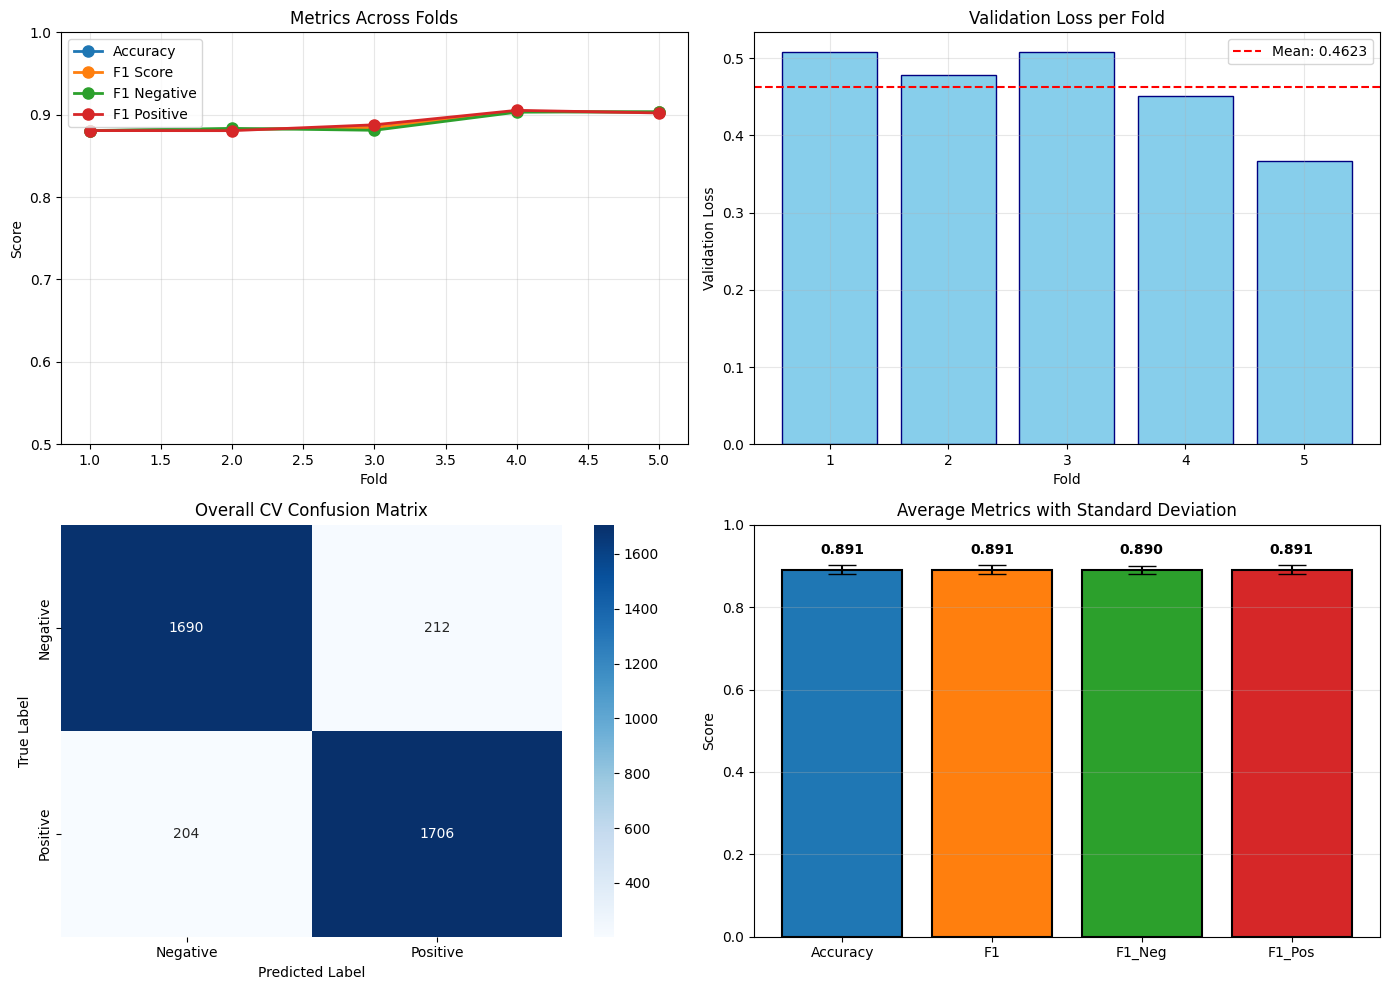


DETAILED CLASSIFICATION REPORT (CV):
              precision    recall  f1-score   support

    Negative     0.8923    0.8885    0.8904      1902
    Positive     0.8895    0.8932    0.8913      1910

    accuracy                         0.8909      3812
   macro avg     0.8909    0.8909    0.8909      3812
weighted avg     0.8909    0.8909    0.8909      3812



In [12]:
def plot_cv_results(cv_results, avg_metrics, num_classes=2, class_names=None):
    """Create comprehensive visualization of CV results for 2 or 3 classes"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Metrics across folds
    folds = range(1, len(cv_results['fold_metrics']) + 1)
    
    # Build metrics data based on number of classes
    metrics_data = {
        'Accuracy': [m['accuracy'] for m in cv_results['fold_metrics']],
        'F1 Score': [m['f1'] for m in cv_results['fold_metrics']],
    }
    
    if num_classes == 2:
        metrics_data['F1 Negative'] = [m['f1_negative'] for m in cv_results['fold_metrics']]
        metrics_data['F1 Positive'] = [m['f1_positive'] for m in cv_results['fold_metrics']]
    else:
        if 'f1_macro' in cv_results['fold_metrics'][0]:
            metrics_data['F1 Macro'] = [m['f1_macro'] for m in cv_results['fold_metrics']]
    
    for metric_name, values in metrics_data.items():
        axes[0, 0].plot(folds, values, 'o-', label=metric_name, linewidth=2, markersize=8)
    
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Metrics Across Folds')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0.5, 1.0])
    
    # 2. Loss across folds
    losses = [m['loss'] for m in cv_results['fold_metrics']]
    axes[0, 1].bar(folds, losses, color='skyblue', edgecolor='navy')
    axes[0, 1].axhline(y=np.mean(losses), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(losses):.4f}')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].set_title('Validation Loss per Fold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Overall confusion matrix
    cm = confusion_matrix(cv_results['all_labels'], cv_results['all_predictions'])
    labels = [class_names[i] for i in range(num_classes)]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=labels,
                yticklabels=labels)
    axes[1, 0].set_title('Overall CV Confusion Matrix')
    axes[1, 0].set_ylabel('True Label')
    axes[1, 0].set_xlabel('Predicted Label')
    
    # 4. Metrics summary with error bars
    if num_classes == 2:
        metric_names = ['Accuracy', 'F1', 'F1_Neg', 'F1_Pos']
        means = [avg_metrics['accuracy']['mean'], avg_metrics['f1']['mean'],
                 avg_metrics['f1_negative']['mean'], avg_metrics['f1_positive']['mean']]
        stds = [avg_metrics['accuracy']['std'], avg_metrics['f1']['std'],
                avg_metrics['f1_negative']['std'], avg_metrics['f1_positive']['std']]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    else:
        metric_names = ['Accuracy', 'F1', 'F1_Macro']
        means = [avg_metrics['accuracy']['mean'], avg_metrics['f1']['mean']]
        stds = [avg_metrics['accuracy']['std'], avg_metrics['f1']['std']]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        if 'f1_macro' in avg_metrics:
            means.append(avg_metrics['f1_macro']['mean'])
            stds.append(avg_metrics['f1_macro']['std'])
            
        # Add per-class F1 if available
        for i in range(num_classes):
            if f'f1_class_{i}' in avg_metrics:
                metric_names.append(f'F1_{class_names[i][:3]}')
                means.append(avg_metrics[f'f1_class_{i}']['mean'])
                stds.append(avg_metrics[f'f1_class_{i}']['std'])
                colors.append(plt.cm.tab10(i+3))
    
    x_pos = np.arange(len(metric_names))
    axes[1, 1].bar(x_pos, means, yerr=stds, capsize=10, 
                   color=colors[:len(metric_names)],
                   edgecolor='black', linewidth=1.5)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(metric_names, rotation=45 if len(metric_names) > 4 else 0)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Average Metrics with Standard Deviation')
    axes[1, 1].set_ylim([0, 1.0])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[1, 1].text(i, mean + std + 0.02, f'{mean:.3f}', 
                        ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'plots/cv_results_summary_{SELECTED_MODEL}_{num_classes}class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print classification report
    print("\nDETAILED CLASSIFICATION REPORT (CV):")
    print("="*70)
    labels_list = [class_names[i] for i in range(num_classes)]
    print(classification_report(cv_results['all_labels'], cv_results['all_predictions'],
                              target_names=labels_list, digits=4))

# Plot results with dynamic class handling
plot_cv_results(cv_results, avg_metrics, num_classes=num_classes, class_names=class_names)

## 11. Final Model Training

In [13]:
def train_final_model(df, model_config, training_config, use_augmentation=True, num_classes=2, class_names=None):
    """Train final model on full dataset with proper train/val/test split"""
    
    print(f"\nTraining final model with: {model_config['name']}")
    print("="*70)
    
    # Split data
    X = df['Text'].values
    y = df['Polarity'].values
    
    # First split: 80% train+val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Second split: 75% train, 25% val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )
    
    print("\nData Split Summary:")
    print("="*50)
    print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Val: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"\nTrain class distribution: {np.bincount(y_train)}")
    print(f"Val class distribution: {np.bincount(y_val)}")
    print(f"Test class distribution: {np.bincount(y_test)}")
    
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_config['name'])
    
    # Create datasets
    train_dataset = BanglaDataset(
        X_train, y_train, tokenizer,
        max_length=model_config['max_length'],
        is_training=True,
        augment=use_augmentation
    )
    
    val_dataset = BanglaDataset(
        X_val, y_val, tokenizer,
        max_length=model_config['max_length'],
        is_training=False,
        augment=False
    )
    
    test_dataset = BanglaDataset(
        X_test, y_test, tokenizer,
        max_length=model_config['max_length'],
        is_training=False,
        augment=False
    )
    
    # Initialize model
    model = ImprovedBanglaClassifier(
        model_config['name'],
        num_labels=num_classes,
        config=training_config
    ).to(device)
    
    print(f"\nModel initialized: {model_config['name']}")
    print(f"Model type: {model_config['model_type']}")
    print(f"Number of classes: {num_classes}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Create trainer
    trainer = CustomTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        config=training_config,
        device=device
    )
    
    # Train model
    print("\n" + "="*70)
    print(f"TRAINING FINAL MODEL: {model_config['model_type']}")
    print("="*70)
    
    train_history = trainer.train()
    
    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=training_config['batch_size'] * 2,
        shuffle=False,
        num_workers=2
    )
    
    test_metrics, test_predictions, test_labels, test_probs = trainer.evaluate(test_loader)
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'trainer': trainer,
        'test_metrics': test_metrics,
        'test_predictions': test_predictions,
        'test_labels': test_labels,
        'test_probs': test_probs,
        'train_history': train_history,
        'data_splits': {
            'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
            'y_train': y_train, 'y_val': y_val, 'y_test': y_test
        },
        'num_classes': num_classes,
        'class_names': class_names,
        'model_config': model_config
    }

# Train final model with SELECTED MODEL
final_results = train_final_model(
    df_clean,
    MODEL_CONFIGS[SELECTED_MODEL],  # Uses the selected model
    TRAINING_CONFIG,
    use_augmentation=True,
    num_classes=num_classes,
    class_names=class_names
)


Training final model with: csebuetnlp/banglabert

Data Split Summary:
Train: 2286 samples (60.0%)
Val: 763 samples (20.0%)
Test: 763 samples (20.0%)

Train class distribution: [1140 1146]
Val class distribution: [381 382]
Test class distribution: [381 382]


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model hidden size: 768
Number of labels: 2

Model initialized: csebuetnlp/banglabert
Model type: banglabert
Number of classes: 2
Total parameters: 110,915,714
Trainable parameters: 110,915,714

TRAINING FINAL MODEL: banglabert

Starting training...


Training Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 1/15
Train Loss: 0.6918, Train Acc: 0.5486
Val Loss: 0.5953, Val Acc: 0.6959
Val F1: 0.6946 (Neg: 0.6742, Pos: 0.7150)
✓ New best model! F1: 0.6946
----------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/72 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 14

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 2/15
Train Loss: 0.5138, Train Acc: 0.7883
Val Loss: 0.4314, Val Acc: 0.8729
Val F1: 0.8727 (Neg: 0.8680, Pos: 0.8774)
✓ New best model! F1: 0.8727
----------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 3/15
Train Loss: 0.3780, Train Acc: 0.8963
Val Loss: 0.4655, Val Acc: 0.8480
Val F1: 0.8466 (Neg: 0.8319, Pos: 0.8612)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 4/15
Train Loss: 0.3280, Train Acc: 0.9256
Val Loss: 0.4406, Val Acc: 0.8834
Val F1: 0.8832 (Neg: 0.8782, Pos: 0.8881)
✓ New best model! F1: 0.8832
----------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0><function _MultiProcessingDataLoaderIter.__del__ at 0x7de3adde3ba0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
 if w.is_alive():
            ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._par


Epoch 5/15
Train Loss: 0.2860, Train Acc: 0.9519
Val Loss: 0.5244, Val Acc: 0.8558
Val F1: 0.8544 (Neg: 0.8401, Pos: 0.8687)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 6/15
Train Loss: 0.2618, Train Acc: 0.9676
Val Loss: 0.4701, Val Acc: 0.8860
Val F1: 0.8858 (Neg: 0.8813, Pos: 0.8903)
✓ New best model! F1: 0.8858
----------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 7/15
Train Loss: 0.2421, Train Acc: 0.9799
Val Loss: 0.4472, Val Acc: 0.8965
Val F1: 0.8965 (Neg: 0.8959, Pos: 0.8970)
✓ New best model! F1: 0.8965
----------------------------------------------------------------------


Training Epoch 8:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 8/15
Train Loss: 0.2300, Train Acc: 0.9843
Val Loss: 0.4940, Val Acc: 0.8755
Val F1: 0.8751 (Neg: 0.8682, Pos: 0.8820)
✗ No improvement. Patience: 1/7
----------------------------------------------------------------------


Training Epoch 9:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 9/15
Train Loss: 0.2244, Train Acc: 0.9869
Val Loss: 0.4707, Val Acc: 0.8886
Val F1: 0.8886 (Neg: 0.8868, Pos: 0.8903)
✗ No improvement. Patience: 2/7
----------------------------------------------------------------------


Training Epoch 10:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 10/15
Train Loss: 0.2149, Train Acc: 0.9939
Val Loss: 0.4805, Val Acc: 0.8952
Val F1: 0.8951 (Neg: 0.8930, Pos: 0.8972)
✗ No improvement. Patience: 3/7
----------------------------------------------------------------------


Training Epoch 11:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 11/15
Train Loss: 0.2158, Train Acc: 0.9930
Val Loss: 0.4758, Val Acc: 0.8925
Val F1: 0.8925 (Neg: 0.8915, Pos: 0.8935)
✗ No improvement. Patience: 4/7
----------------------------------------------------------------------


Training Epoch 12:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 12/15
Train Loss: 0.2126, Train Acc: 0.9948
Val Loss: 0.4847, Val Acc: 0.8899
Val F1: 0.8898 (Neg: 0.8868, Pos: 0.8929)
✗ No improvement. Patience: 5/7
----------------------------------------------------------------------


Training Epoch 13:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 13/15
Train Loss: 0.2134, Train Acc: 0.9930
Val Loss: 0.4745, Val Acc: 0.8912
Val F1: 0.8912 (Neg: 0.8898, Pos: 0.8926)
✗ No improvement. Patience: 6/7
----------------------------------------------------------------------


Training Epoch 14:   0%|          | 0/72 [00:10<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


Epoch 14/15
Train Loss: 0.2145, Train Acc: 0.9926
Val Loss: 0.4817, Val Acc: 0.8873
Val F1: 0.8872 (Neg: 0.8838, Pos: 0.8906)
✗ No improvement. Patience: 7/7

Early stopping triggered after 14 epochs

Loaded best model with F1: 0.8965

EVALUATING ON TEST SET


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

## 12. Final Model Evaluation


FINAL MODEL TEST RESULTS
Test Accuracy: 0.8781
Test F1 Score: 0.8780
Test F1 Negative: 0.8745
Test F1 Positive: 0.8815
Test Loss: 0.5182

GENERALIZATION ANALYSIS
CV Mean Accuracy: 0.8909
Test Accuracy: 0.8781
Difference: -0.0128
✓ Good generalization - test performance close to CV


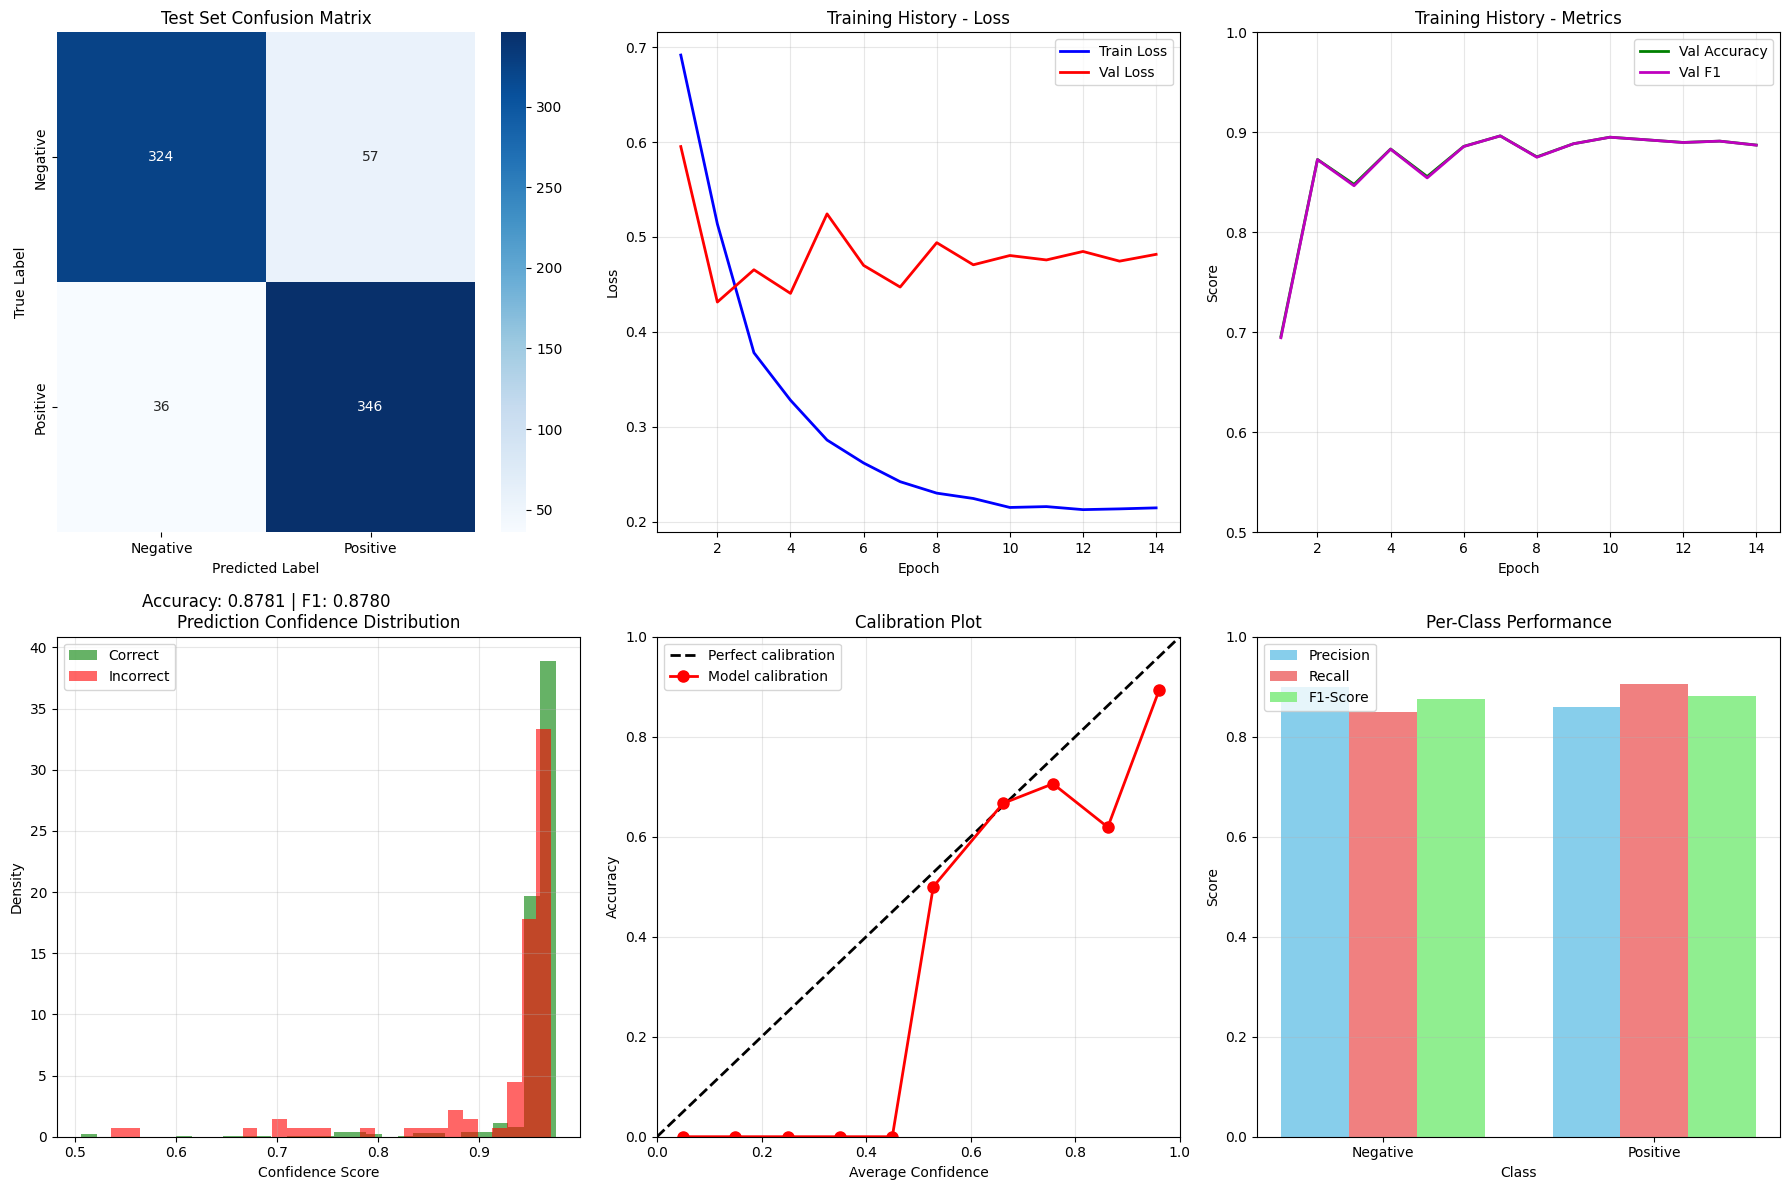


DETAILED CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

    Negative     0.9000    0.8504    0.8745       381
    Positive     0.8586    0.9058    0.8815       382

    accuracy                         0.8781       763
   macro avg     0.8793    0.8781    0.8780       763
weighted avg     0.8793    0.8781    0.8780       763


CONFIDENCE ANALYSIS
Mean confidence (all): 0.9487
Mean confidence (correct): 0.9522
Mean confidence (incorrect): 0.9237
Low confidence predictions (<0.6): 4 (0.5%)
High confidence predictions (>0.9): 715 (93.7%)


In [14]:
# Comprehensive evaluation of final model
def evaluate_final_model(final_results, cv_results=None):
    """Comprehensive evaluation and visualization of final model"""
    
    test_metrics = final_results['test_metrics']
    test_predictions = final_results['test_predictions']
    test_labels = final_results['test_labels']
    test_probs = final_results['test_probs']
    
    print("\n" + "="*70)
    print("FINAL MODEL TEST RESULTS")
    print("="*70)
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 Score: {test_metrics['f1']:.4f}")
    print(f"Test F1 Negative: {test_metrics['f1_negative']:.4f}")
    print(f"Test F1 Positive: {test_metrics['f1_positive']:.4f}")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    
    # Compare with CV if available
    if cv_results is not None:
        cv_mean_acc = np.mean([m['accuracy'] for m in cv_results['fold_metrics']])
        cv_mean_f1 = np.mean([m['f1'] for m in cv_results['fold_metrics']])
        
        print("\n" + "="*70)
        print("GENERALIZATION ANALYSIS")
        print("="*70)
        print(f"CV Mean Accuracy: {cv_mean_acc:.4f}")
        print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Difference: {test_metrics['accuracy'] - cv_mean_acc:.4f}")
        
        if abs(test_metrics['accuracy'] - cv_mean_acc) < 0.05:
            print("✓ Good generalization - test performance close to CV")
        elif test_metrics['accuracy'] < cv_mean_acc - 0.05:
            print("⚠ Slight overfitting detected")
        else:
            print("✓ Test performance better than CV average")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(test_labels, test_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[0, 0].set_title('Test Set Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')
    
    # Add metrics text
    accuracy = np.trace(cm) / np.sum(cm)
    axes[0, 0].text(0.5, -0.15, f'Accuracy: {accuracy:.4f} | F1: {test_metrics["f1"]:.4f}',
                    ha='center', transform=axes[0, 0].transAxes, fontsize=12)
    
    # 2. Training History
    train_history = final_results['train_history']
    epochs = range(1, len(train_history['train_losses']) + 1)
    
    axes[0, 1].plot(epochs, train_history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 1].plot(epochs, train_history['val_losses'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Training History - Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Metrics History
    val_accs = [m['accuracy'] for m in train_history['val_metrics']]
    val_f1s = [m['f1'] for m in train_history['val_metrics']]
    
    axes[0, 2].plot(epochs, val_accs, 'g-', label='Val Accuracy', linewidth=2)
    axes[0, 2].plot(epochs, val_f1s, 'm-', label='Val F1', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_title('Training History - Metrics')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim([0.5, 1.0])
    
    # 4. Confidence Distribution
    confidence_scores = np.max(test_probs, axis=1)
    correct_mask = test_predictions == test_labels
    
    axes[1, 0].hist(confidence_scores[correct_mask], bins=30, alpha=0.6, 
                    label='Correct', density=True, color='green')
    axes[1, 0].hist(confidence_scores[~correct_mask], bins=30, alpha=0.6, 
                    label='Incorrect', density=True, color='red')
    axes[1, 0].set_xlabel('Confidence Score')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Confidence Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Calibration Plot
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    
    accuracies = []
    avg_confidences = []
    
    for i in range(n_bins):
        mask = (confidence_scores >= bin_boundaries[i]) & (confidence_scores < bin_boundaries[i+1])
        if mask.sum() > 0:
            accuracies.append((test_predictions[mask] == test_labels[mask]).mean())
            avg_confidences.append(confidence_scores[mask].mean())
        else:
            accuracies.append(0)
            avg_confidences.append(bin_centers[i])
    
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=2)
    axes[1, 1].plot(avg_confidences, accuracies, 'ro-', label='Model calibration', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Average Confidence')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Calibration Plot')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim([0, 1])
    axes[1, 1].set_ylim([0, 1])
    
    # 6. Per-class Performance
    class_names = ['Negative', 'Positive']
    precision = []
    recall = []
    f1_scores = []
    
    for i in range(2):
        mask = test_labels == i
        if mask.sum() > 0:
            correct = (test_predictions[mask] == i).sum()
            predicted_as_class = (test_predictions == i).sum()
            
            prec = correct / predicted_as_class if predicted_as_class > 0 else 0
            rec = correct / mask.sum()
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
            
            precision.append(prec)
            recall.append(rec)
            f1_scores.append(f1)
    
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[1, 2].bar(x - width, precision, width, label='Precision', color='skyblue')
    axes[1, 2].bar(x, recall, width, label='Recall', color='lightcoral')
    axes[1, 2].bar(x + width, f1_scores, width, label='F1-Score', color='lightgreen')
    
    axes[1, 2].set_xlabel('Class')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('Per-Class Performance')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(class_names)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    axes[1, 2].set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.savefig(f'plots/final_model_evaluation_{SELECTED_MODEL}_{num_classes}class.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed classification report
    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT (TEST SET)")
    print("="*70)
    print(classification_report(test_labels, test_predictions,
                              target_names=['Negative', 'Positive'], digits=4))
    
    # Confidence statistics
    print("\n" + "="*70)
    print("CONFIDENCE ANALYSIS")
    print("="*70)
    print(f"Mean confidence (all): {confidence_scores.mean():.4f}")
    print(f"Mean confidence (correct): {confidence_scores[correct_mask].mean():.4f}")
    print(f"Mean confidence (incorrect): {confidence_scores[~correct_mask].mean():.4f}")
    print(f"Low confidence predictions (<0.6): {(confidence_scores < 0.6).sum()} ({(confidence_scores < 0.6).mean()*100:.1f}%)")
    print(f"High confidence predictions (>0.9): {(confidence_scores > 0.9).sum()} ({(confidence_scores > 0.9).mean()*100:.1f}%)")

# Evaluate final model
evaluate_final_model(final_results, cv_results)

## 13. Error Analysis

DETAILED ERROR ANALYSIS

Error Statistics:
Total errors: 93/763 (12.19%)

Error Breakdown:
False Positives (Neg→Pos): 57 (7.47%)
False Negatives (Pos→Neg): 36 (4.72%)

Confidence Analysis:
Mean confidence (errors): 0.9237
Mean confidence (correct): 0.9522
Std confidence (errors): 0.0871
Std confidence (correct): 0.0457

High confidence errors (>0.8): 84 (90.3% of errors)

Text Length Analysis:
Avg length (errors): 62.3 chars
Avg length (correct): 66.0 chars
Length difference: -3.7 chars

SAMPLE MISCLASSIFIED TEXTS

False Positives (Negative → Positive):
--------------------------------------------------

Text: মি আগিই বলছি আমরা এমন কিছু করতে পারি যা অন্যান্য দেশের মানুষ ভাবতেও পারেনা....
Confidence: 0.9615
Probabilities: [Neg: 0.0385, Pos: 0.9615]

Text: বাংলাদেশ ক্রমান্বয়ে উন্নতি করছে ১ম ইনিংসে ১১০ রান করলেও ২য় ইনিংসে ১২৩ রান করছে। চোখে পড়ার মত উন্নতি।...
Confidence: 0.9639
Probabilities: [Neg: 0.0361, Pos: 0.9639]

Text: এই প্রতিবন্ধী সূজন(আপদজন) ই হোক বাংলাদেশের ভবিষ্যৎ কোচ....
C

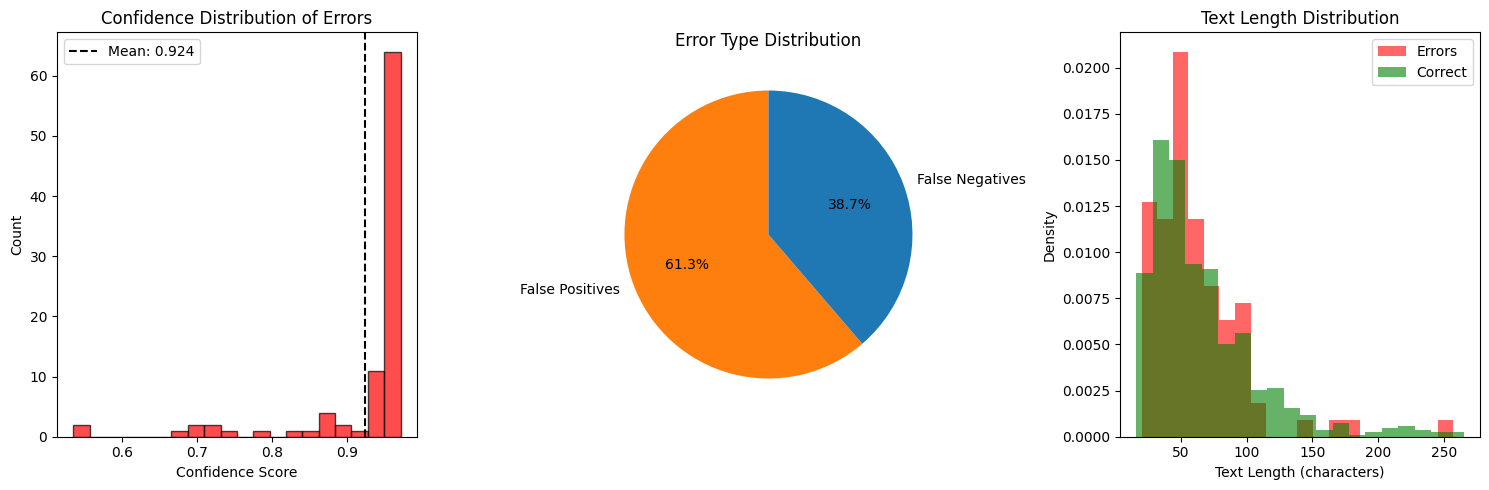

In [15]:
def detailed_error_analysis(final_results):
    """Perform detailed error analysis"""
    
    test_predictions = final_results['test_predictions']
    test_labels = final_results['test_labels']
    test_probs = final_results['test_probs']
    X_test = final_results['data_splits']['X_test']
    
    errors = test_predictions != test_labels
    error_indices = np.where(errors)[0]
    
    print("="*70)
    print("DETAILED ERROR ANALYSIS")
    print("="*70)
    
    # Error statistics
    print(f"\nError Statistics:")
    print(f"Total errors: {len(error_indices)}/{len(test_labels)} ({len(error_indices)/len(test_labels)*100:.2f}%)")
    
    # Error breakdown
    fp_mask = (test_labels == 0) & (test_predictions == 1)
    fn_mask = (test_labels == 1) & (test_predictions == 0)
    
    print(f"\nError Breakdown:")
    print(f"False Positives (Neg→Pos): {fp_mask.sum()} ({fp_mask.sum()/len(test_labels)*100:.2f}%)")
    print(f"False Negatives (Pos→Neg): {fn_mask.sum()} ({fn_mask.sum()/len(test_labels)*100:.2f}%)")
    
    # Confidence analysis for errors
    error_confidences = np.max(test_probs[errors], axis=1)
    correct_confidences = np.max(test_probs[~errors], axis=1)
    
    print(f"\nConfidence Analysis:")
    print(f"Mean confidence (errors): {error_confidences.mean():.4f}")
    print(f"Mean confidence (correct): {correct_confidences.mean():.4f}")
    print(f"Std confidence (errors): {error_confidences.std():.4f}")
    print(f"Std confidence (correct): {correct_confidences.std():.4f}")
    
    # High confidence errors
    high_conf_errors = error_confidences > 0.8
    print(f"\nHigh confidence errors (>0.8): {high_conf_errors.sum()} ({high_conf_errors.sum()/len(error_confidences)*100:.1f}% of errors)")
    
    # Length analysis
    error_lengths = [len(X_test[i]) for i in error_indices]
    correct_lengths = [len(X_test[i]) for i in range(len(X_test)) if i not in error_indices]
    
    print(f"\nText Length Analysis:")
    print(f"Avg length (errors): {np.mean(error_lengths):.1f} chars")
    print(f"Avg length (correct): {np.mean(correct_lengths):.1f} chars")
    print(f"Length difference: {np.mean(error_lengths) - np.mean(correct_lengths):.1f} chars")
    
    # Sample errors
    print("\n" + "="*70)
    print("SAMPLE MISCLASSIFIED TEXTS")
    print("="*70)
    
    # False Positives
    fp_indices = np.where(fp_mask)[0]
    if len(fp_indices) > 0:
        print("\nFalse Positives (Negative → Positive):")
        print("-"*50)
        sample_size = min(5, len(fp_indices))
        for idx in np.random.choice(fp_indices, sample_size, replace=False):
            print(f"\nText: {X_test[idx][:150]}...")
            print(f"Confidence: {np.max(test_probs[idx]):.4f}")
            print(f"Probabilities: [Neg: {test_probs[idx][0]:.4f}, Pos: {test_probs[idx][1]:.4f}]")
    
    # False Negatives
    fn_indices = np.where(fn_mask)[0]
    if len(fn_indices) > 0:
        print("\nFalse Negatives (Positive → Negative):")
        print("-"*50)
        sample_size = min(5, len(fn_indices))
        for idx in np.random.choice(fn_indices, sample_size, replace=False):
            print(f"\nText: {X_test[idx][:150]}...")
            print(f"Confidence: {np.max(test_probs[idx]):.4f}")
            print(f"Probabilities: [Neg: {test_probs[idx][0]:.4f}, Pos: {test_probs[idx][1]:.4f}]")
    
    # Error patterns visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Error confidence distribution
    axes[0].hist(error_confidences, bins=20, alpha=0.7, color='red', edgecolor='black')
    axes[0].set_xlabel('Confidence Score')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Confidence Distribution of Errors')
    axes[0].axvline(x=error_confidences.mean(), color='black', linestyle='--', 
                    label=f'Mean: {error_confidences.mean():.3f}')
    axes[0].legend()
    
    # 2. Error types
    error_types = ['False Positives', 'False Negatives']
    error_counts = [fp_mask.sum(), fn_mask.sum()]
    colors = ['#ff7f0e', '#1f77b4']
    
    axes[1].pie(error_counts, labels=error_types, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title('Error Type Distribution')
    
    # 3. Length distribution of errors
    axes[2].hist(error_lengths, bins=20, alpha=0.6, color='red', label='Errors', density=True)
    axes[2].hist(correct_lengths, bins=20, alpha=0.6, color='green', label='Correct', density=True)
    axes[2].set_xlabel('Text Length (characters)')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Text Length Distribution')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig(f'plots/error_analysis_{SELECTED_MODEL}_{num_classes}class.png', dpi=300, bbox_inches='tight')
    plt.show()

# Perform error analysis
detailed_error_analysis(final_results)

## 14. Save Model and Results

In [16]:
def save_model_and_results(final_results, cv_results, model_config, training_config):
    """Save the trained model and comprehensive results"""
    
    model = final_results['model']
    tokenizer = final_results['tokenizer']
    test_metrics = final_results['test_metrics']
    
    # Determine if model meets performance threshold
    performance_threshold = 0.75  # Adjusted for realistic expectations
    
    if test_metrics['accuracy'] >= performance_threshold:
        # Save model with model-specific path
        model_save_path = f"./models/bangla_sentiment_{model_config['model_type']}_{num_classes}class"
        os.makedirs(model_save_path, exist_ok=True)
        
        # Save model state dict
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_config': model_config,
            'training_config': training_config,
            'test_metrics': test_metrics,
            'num_classes': num_classes,
            'class_names': class_names
        }, f"{model_save_path}/model.pt")
        
        # Save tokenizer
        tokenizer.save_pretrained(model_save_path)
        
        print(f"✓ Model saved to: {model_save_path}")
    else:
        print(f"✗ Model performance ({test_metrics['accuracy']:.4f}) below threshold ({performance_threshold})")
    
    # Save comprehensive results with model-specific filename
    results_summary = {
        'model_info': {
            'name': model_config['name'],
            'type': model_config['model_type'],
            'max_length': model_config['max_length']
        },
        'training_config': training_config,
        'cv_results': {
            'fold_metrics': cv_results['fold_metrics'],
            'avg_accuracy': np.mean([m['accuracy'] for m in cv_results['fold_metrics']]),
            'avg_f1': np.mean([m['f1'] for m in cv_results['fold_metrics']]),
            'std_accuracy': np.std([m['accuracy'] for m in cv_results['fold_metrics']]),
            'std_f1': np.std([m['f1'] for m in cv_results['fold_metrics']])
        },
        'test_results': test_metrics,
        'dataset_info': {
            'total_samples': len(df_clean),
            'train_samples': len(final_results['data_splits']['X_train']),
            'val_samples': len(final_results['data_splits']['X_val']),
            'test_samples': len(final_results['data_splits']['X_test']),
            'num_classes': num_classes
        },
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    # Save as JSON with model-specific filename
    results_filename = f'results/training_results_{model_config["model_type"]}_{num_classes}class.json'
    with open(results_filename, 'w', encoding='utf-8') as f:
        json.dump(results_summary, f, indent=4, ensure_ascii=False)
    
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"Model: {model_config['name']} ({model_config['model_type']})")
    print(f"Number of classes: {num_classes}")
    print(f"CV Accuracy: {results_summary['cv_results']['avg_accuracy']:.4f} ± {results_summary['cv_results']['std_accuracy']:.4f}")
    print(f"CV F1: {results_summary['cv_results']['avg_f1']:.4f} ± {results_summary['cv_results']['std_f1']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1: {test_metrics['f1']:.4f}")
    print(f"\nResults saved to: {results_filename}")
    
    return results_summary

# Save model and results with SELECTED MODEL configuration
results_summary = save_model_and_results(
    final_results, 
    cv_results, 
    MODEL_CONFIGS[SELECTED_MODEL],  # Uses the selected model config
    TRAINING_CONFIG
)

✓ Model saved to: ./models/bangla_sentiment_banglabert_2class

FINAL SUMMARY
Model: csebuetnlp/banglabert (banglabert)
Number of classes: 2
CV Accuracy: 0.8909 ± 0.0104
CV F1: 0.8909 ± 0.0104
Test Accuracy: 0.8781
Test F1: 0.8780

Results saved to: results/training_results_banglabert_2class.json


## 15. Model Inference

In [17]:
class SentimentPredictor:
    """Sentiment prediction interface for 2 or 3 classes"""
    
    def __init__(self, model_path=None, model=None, tokenizer=None, device='cuda', num_classes=2, class_names=None):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.num_classes = num_classes
        self.class_names = class_names or {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
        
        if model is not None and tokenizer is not None:
            self.model = model
            self.tokenizer = tokenizer
        else:
            # Load from path
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            checkpoint = torch.load(f"{model_path}/model.pt", map_location=self.device)
            
            # Recreate model
            model_config = checkpoint['model_config']
            self.model = ImprovedBanglaClassifier(
                model_config['name'],
                num_labels=self.num_classes,
                config=checkpoint['training_config']
            )
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.model.to(self.device)
        
        self.model.eval()
    
    def predict(self, text, return_probs=True):
        """Predict sentiment for a single text"""
        
        # Tokenize
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs['logits']
            probs = F.softmax(logits, dim=-1)
        
        # Get prediction
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = torch.max(probs).item()
        
        result = {
            'sentiment': self.class_names[pred_class],
            'confidence': confidence,
            'label': pred_class
        }
        
        if return_probs:
            result['probabilities'] = {}
            for i in range(self.num_classes):
                result['probabilities'][self.class_names[i].lower()] = probs[0][i].item()
        
        return result
    
    def predict_batch(self, texts, batch_size=32):
        """Predict sentiment for multiple texts"""
        results = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize batch
            inputs = self.tokenizer(
                batch_texts,
                truncation=True,
                padding='max_length',
                max_length=128,
                return_tensors='pt'
            )
            
            # Move to device
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Predict
            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs['logits']
                probs = F.softmax(logits, dim=-1)
            
            # Process predictions
            pred_classes = torch.argmax(probs, dim=-1)
            confidences = torch.max(probs, dim=-1).values
            
            for j in range(len(batch_texts)):
                prob_dict = {}
                for k in range(self.num_classes):
                    prob_dict[self.class_names[k].lower()] = probs[j][k].item()
                
                results.append({
                    'text': batch_texts[j],
                    'sentiment': self.class_names[pred_classes[j].item()],
                    'confidence': confidences[j].item(),
                    'probabilities': prob_dict
                })
        
        return results

# Initialize predictor with the trained model
predictor = SentimentPredictor(
    model=final_results['model'],
    tokenizer=final_results['tokenizer'],
    device=device,
    num_classes=num_classes,
    class_names=class_names
)

# Test examples - adjust based on number of classes
if num_classes == 2:
    test_examples = [
        "এই পণ্যটি খুবই ভালো, আমি খুব সন্তুষ্ট।",
        "সার্ভিস একদম বাজে, কখনো কিনবেন না।",
        "অসাধারণ! আমার খুব পছন্দ হয়েছে।",
        "খুবই হতাশাজনক অভিজ্ঞতা।",
        "চমৎকার পণ্য, সবাইকে রিকমেন্ড করবো।",
        "একদম পছন্দ হয়নি, টাকা নষ্ট।"
    ]
else:
    test_examples = [
        "এই পণ্যটি খুবই ভালো, আমি খুব সন্তুষ্ট।",
        "সার্ভিস একদম বাজে, কখনো কিনবেন না।",
        "মোটামুটি ঠিক আছে, দাম অনুযায়ী ভালো।",
        "অসাধারণ! আমার খুব পছন্দ হয়েছে।",
        "খুবই হতাশাজনক অভিজ্ঞতা।",
        "দামের তুলনায় কোয়ালিটি ভালো।",
        "একদম পছন্দ হয়নি, টাকা নষ্ট।",
        "চমৎকার পণ্য, সবাইকে রিকমেন্ড করবো।"
    ]

print("SENTIMENT PREDICTIONS")
print("="*70)
print(f"{'Text':<50} {'Sentiment':<10} {'Confidence':<10}")
print("-"*70)

for text in test_examples:
    result = predictor.predict(text)
    text_display = text[:47] + "..." if len(text) > 50 else text
    print(f"{text_display:<50} {result['sentiment']:<10} {result['confidence']:<10.4f}")

# Batch prediction example
print("\n\nBATCH PREDICTION EXAMPLE")
print("="*70)
batch_results = predictor.predict_batch(test_examples[:3])
for result in batch_results:
    print(f"\nText: {result['text']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: {', '.join([f'{k.capitalize()}={v:.4f}' for k, v in result['probabilities'].items()])}")

SENTIMENT PREDICTIONS
Text                                               Sentiment  Confidence
----------------------------------------------------------------------


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:147                                                                            │
│                                                                                                  │
│   144 print("-"*70)                                                                              │
│   145                                                                                            │
│   146 for text in test_examples:                                                                 │
│ ❱ 147 │   result = predictor.predict(text)                                                       │
│   148 │   text_display = text[:47] + "..." if len(text) > 50 else text                           │
│   149 │   print(f"{text_display:<50} {result['sentiment']:<10} {result['confidence']:<10.4f}")   │
│   150                                                                                            │
│                                                                                                  │
│ in predict:46                                                                                    │
│                                                                                                  │
│    43 │   │                                                                                      │
│    44 │   │   # Predict                                                                          │
│    45 │   │   with torch.no_grad():                                                              │
│ ❱  46 │   │   │   outputs = self.model(**inputs)                                                 │
│    47 │   │   │   logits = outputs['logits']                                                     │
│    48 │   │   │   probs = F.softmax(logits, dim=-1)                                              │
│    49                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: ImprovedBanglaClassifier.forward() got an unexpected keyword argument 'token_type_ids'

## 16. Deployment Guide and Recommendations

In [ ]:
print("DEPLOYMENT GUIDE AND RECOMMENDATIONS")
print("="*70)

print("\n1. MODEL PERFORMANCE SUMMARY:")
print("-"*50)
print(f"✓ Cross-validation accuracy: {results_summary['cv_results']['avg_accuracy']:.4f}")
print(f"✓ Test set accuracy: {results_summary['test_results']['accuracy']:.4f}")
print(f"✓ Test set F1 score: {results_summary['test_results']['f1']:.4f}")

if results_summary['test_results']['accuracy'] >= 0.80:
    print("\n✓ Model meets deployment criteria (>80% accuracy)")
elif results_summary['test_results']['accuracy'] >= 0.75:
    print("\n⚠ Model performance is acceptable but could be improved")
else:
    print("\n✗ Model needs improvement before deployment")

print("\n2. DEPLOYMENT OPTIONS:")
print("-"*50)
print("a) REST API using FastAPI:")
print("   - Load model once at startup")
print("   - Implement request batching")
print("   - Add rate limiting")
print("   - Monitor response times")

print("\nb) Gradio Interface:")
print("   - Quick web interface for testing")
print("   - Good for internal use")

print("\nc) Production Deployment:")
print("   - Use ONNX for faster inference")
print("   - Implement caching for common queries")
print("   - Set up monitoring and logging")
print("   - Use load balancing for scalability")

print("\n3. MONITORING REQUIREMENTS:")
print("-"*50)
print("✓ Track prediction distribution over time")
print("✓ Monitor confidence scores")
print("✓ Log low-confidence predictions for review")
print("✓ Implement feedback collection")
print("✓ Set up alerts for performance degradation")

print("\n4. IMPROVEMENT RECOMMENDATIONS:")
print("-"*50)
print("✓ Collect more diverse training data")
print("✓ Focus on misclassified examples")
print("✓ Consider ensemble methods")
print("✓ Implement active learning")
print("✓ Regular retraining with new data")

print("\n5. USAGE EXAMPLE:")
print("-"*50)
print("""
from sentiment_predictor import SentimentPredictor

# Load model
predictor = SentimentPredictor(model_path='./models/bangla_sentiment_banglabert')

# Predict
text = "আপনার সার্ভিস খুবই ভালো"
result = predictor.predict(text)

print(f"Sentiment: {result['sentiment']}")
print(f"Confidence: {result['confidence']:.2%}")
""")

print("\n6. API ENDPOINT EXAMPLE:")
print("-"*50)
print("""
@app.post("/predict")
async def predict_sentiment(text: str):
    result = predictor.predict(text)
    return {
        "text": text,
        "sentiment": result['sentiment'],
        "confidence": result['confidence'],
        "probabilities": result['probabilities']
    }
""")

# Create requirements file
requirements = """torch>=2.0.0
transformers>=4.35.0
numpy>=1.21.0
pandas>=1.3.0
scikit-learn>=1.0.0
matplotlib>=3.5.0
seaborn>=0.11.0
tqdm>=4.62.0
fastapi>=0.68.0
uvicorn>=0.15.0
gradio>=3.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("\n7. FILES CREATED:")
print("-"*50)
print("✓ Model files: ./models/bangla_sentiment_banglabert/")
print("✓ Results summary: ./results/training_results_summary.json")
print("✓ Plots: ./plots/")
print("✓ Requirements: ./requirements.txt")

print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)